# Day 8: Convolution - Implementing a Filtering Algorithm

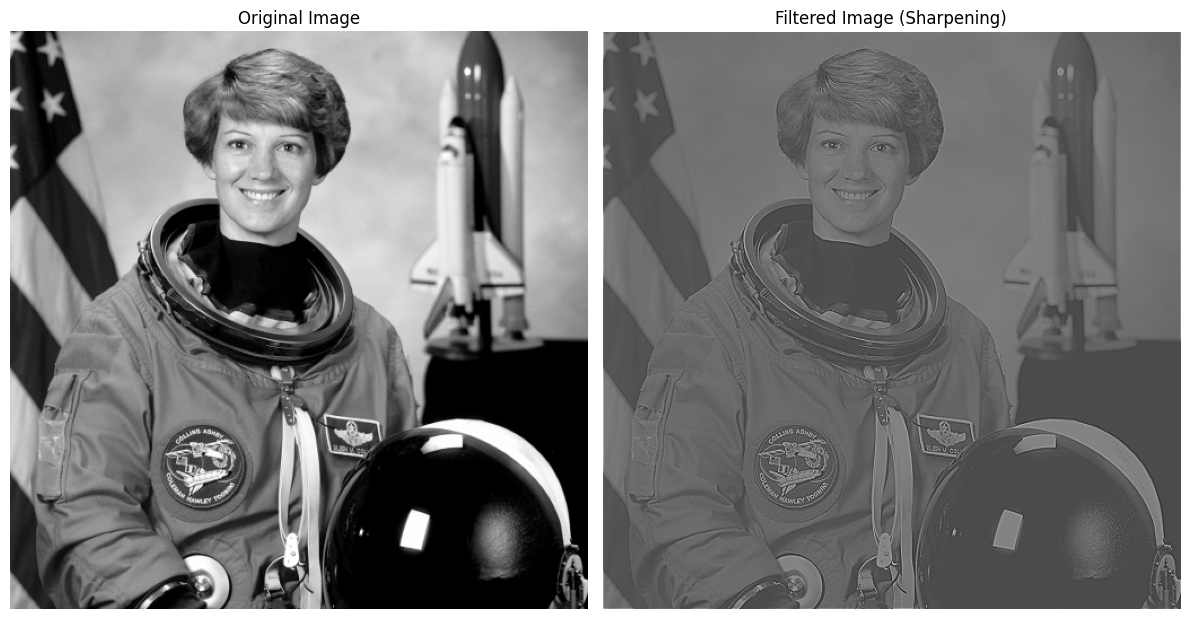

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, color
from skimage.transform import resize

def custom_convolution_2d(image, kernel, padding='same', stride=1):
    # Determine padding size based on the padding type
    if padding == 'same':
        pad_height = kernel.shape[0] // 2
        pad_width = kernel.shape[1] // 2
    elif padding == 'valid':
        pad_height = 0
        pad_width = 0
    else:
        raise ValueError("Unsupported padding type")
    
    # Pad the image
    if len(image.shape) == 3:  # RGB image
        padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    else:  # Grayscale image
        padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    
    # Determine output dimensions
    output_height = (image.shape[0] - kernel.shape[0] + 2 * pad_height) // stride + 1
    output_width = (image.shape[1] - kernel.shape[1] + 2 * pad_width) // stride + 1
    output = np.zeros((output_height, output_width, *image.shape[2:])) if len(image.shape) == 3 else np.zeros((output_height, output_width))
    
    # Perform convolution
    for y in range(output_height):
        for x in range(output_width):
            y_start = y * stride
            x_start = x * stride
            if len(image.shape) == 3:  # RGB image
                for c in range(image.shape[2]):
                    output[y, x, c] = (kernel * padded_image[y_start:y_start + kernel.shape[0], x_start:x_start + kernel.shape[1], c]).sum()
            else:  # Grayscale image
                output[y, x] = (kernel * padded_image[y_start:y_start + kernel.shape[0], x_start:x_start + kernel.shape[1]]).sum()

    return output

# Example usage:
image = color.rgb2gray(data.astronaut())  # Using astronaut image for simplicity
image = resize(image, (512, 512))  # Resize to 512x512 for demonstration

# Define a simple sharpening kernel
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# Apply the convolution function
filtered_image = custom_convolution_2d(image, kernel, padding='same', stride=1)

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Filtered image
axes[1].imshow(filtered_image, cmap='gray')
axes[1].set_title('Filtered Image (Sharpening)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


A complete 2D convolution algorithm should contain these essential elements:

- Core Convolution Operation: Element-wise multiplication of the kernel with image regions and summation of results.
- Multi-channel Support: Ability to process both grayscale and RGB images by handling each channel appropriately.
- Padding Management: Methods to handle image boundaries:
    - 'Valid' padding: Only processes where the kernel completely fits
    - 'Same' padding: Adds zeros around the image to maintain original dimensions
- Stride Parameter: Controls how the kernel moves across the image, affecting output dimensions.


# Day 9: Convolution - Kernels

PROBLEM STATEMENT:
Historical photographs from the Warsaw Uprising (1944) contain various degradations 
including noise, blurring, and low contrast that make details difficult to discern. 
These issues limit their value for historical documentation, education, and preservation.

USE CASE:
Digital restoration and enhancement of historical Warsaw Uprising photographs to:
1. Improve visibility of important historical details
2. Enhance readability of text and identification of individuals
3. Support historical research and education about this pivotal event

OBJECTIVES:
1. Apply various convolution kernels to address specific degradation issues
2. Compare the effectiveness of different restoration approaches
3. Identify optimal parameters for historical photo restoration

BACKGROUND:
The Warsaw Uprising (August-October 1944) was a major World War II operation by the 
Polish resistance to liberate Warsaw from German occupation. During this period, 
approximately 90% of Warsaw was destroyed. Photographic documentation from this era 
is extremely valuable for historical preservation, but many images suffer from quality 
issues due to the difficult conditions under which they were taken and subsequent aging.


DAY 9: CONVOLUTION KERNELS - HISTORICAL PHOTO RESTORATION
----------------------------------------------------------------------

Image loaded and processed: Shape: (512, 512), Type: float64
Region of Interest defined: (70, 250, 240, 360) - focused on faces and document

----------------------------------------------------------------------
EXPERIMENT 1: BASIC RESTORATION TECHNIQUES
----------------------------------------------------------------------
Implementing three basic restoration techniques:

1. Gaussian Smoothing (3x3):
   Purpose: Reduce noise while preserving edges
   Rationale: Historical photos often contain film grain and noise


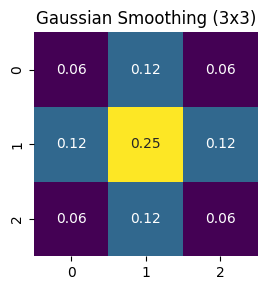


2. Sharpening Kernel (3x3):
   Purpose: Enhance edges and details
   Rationale: Historical photos often suffer from loss of detail and low contrast


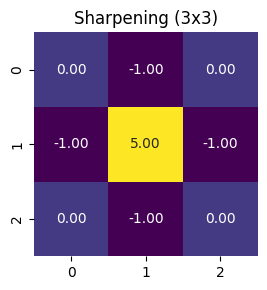


3. Unsharp Masking (5x5):
   Purpose: Enhance details while controlling noise
   Rationale: Combines smoothing with sharpening for balanced restoration


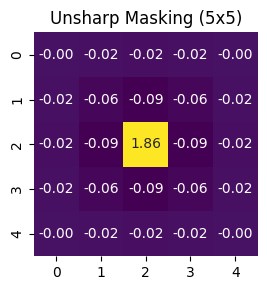

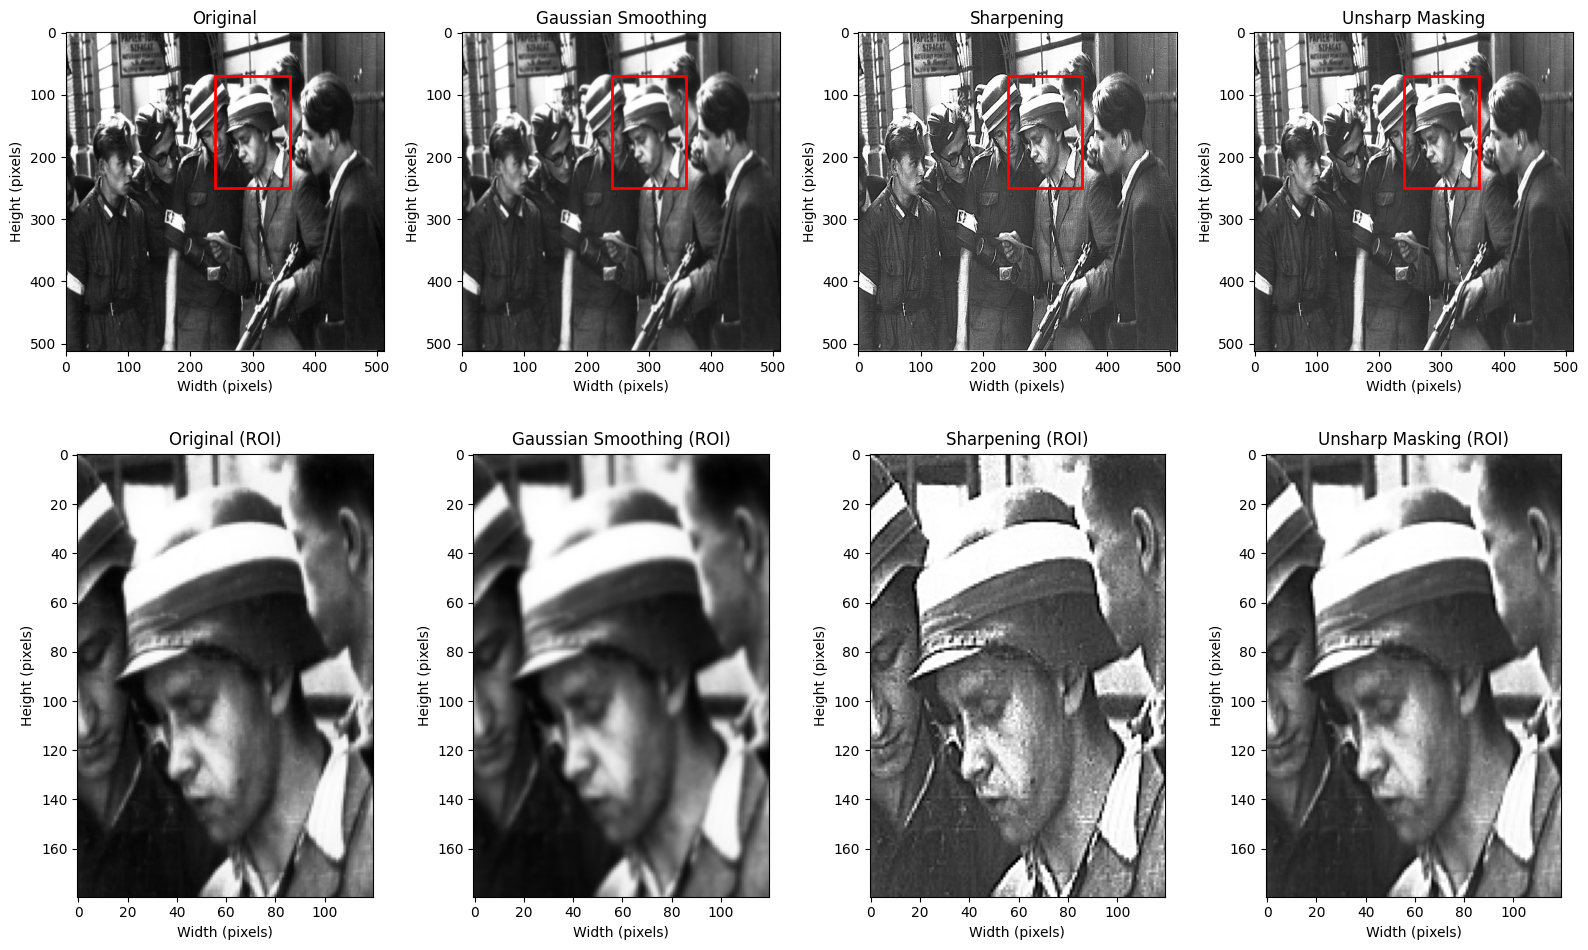


----------------------------------------------------------------------
EXPERIMENT 2: ADVANCED RESTORATION TECHNIQUES
----------------------------------------------------------------------
Implementing three advanced restoration techniques:

1. Detail Preservation Filter (3x3):
   Purpose: Enhance details while minimizing noise amplification
   Rationale: Custom-designed to balance detail enhancement and noise control


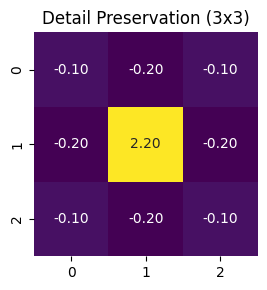


2. Strong Edge Enhancement (3x3):
   Purpose: Significantly enhance edges and structural elements
   Rationale: Stronger parameters for cases where text or facial features need emphasis


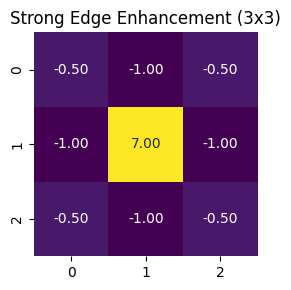


3. Bilateral-Inspired Filter (3x3):
   Purpose: Edge-preserving smoothing
   Rationale: Inspired by bilateral filtering to reduce noise while preserving edges


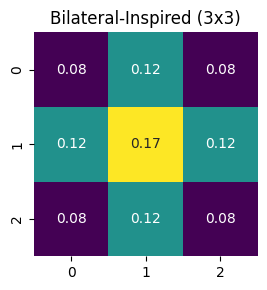

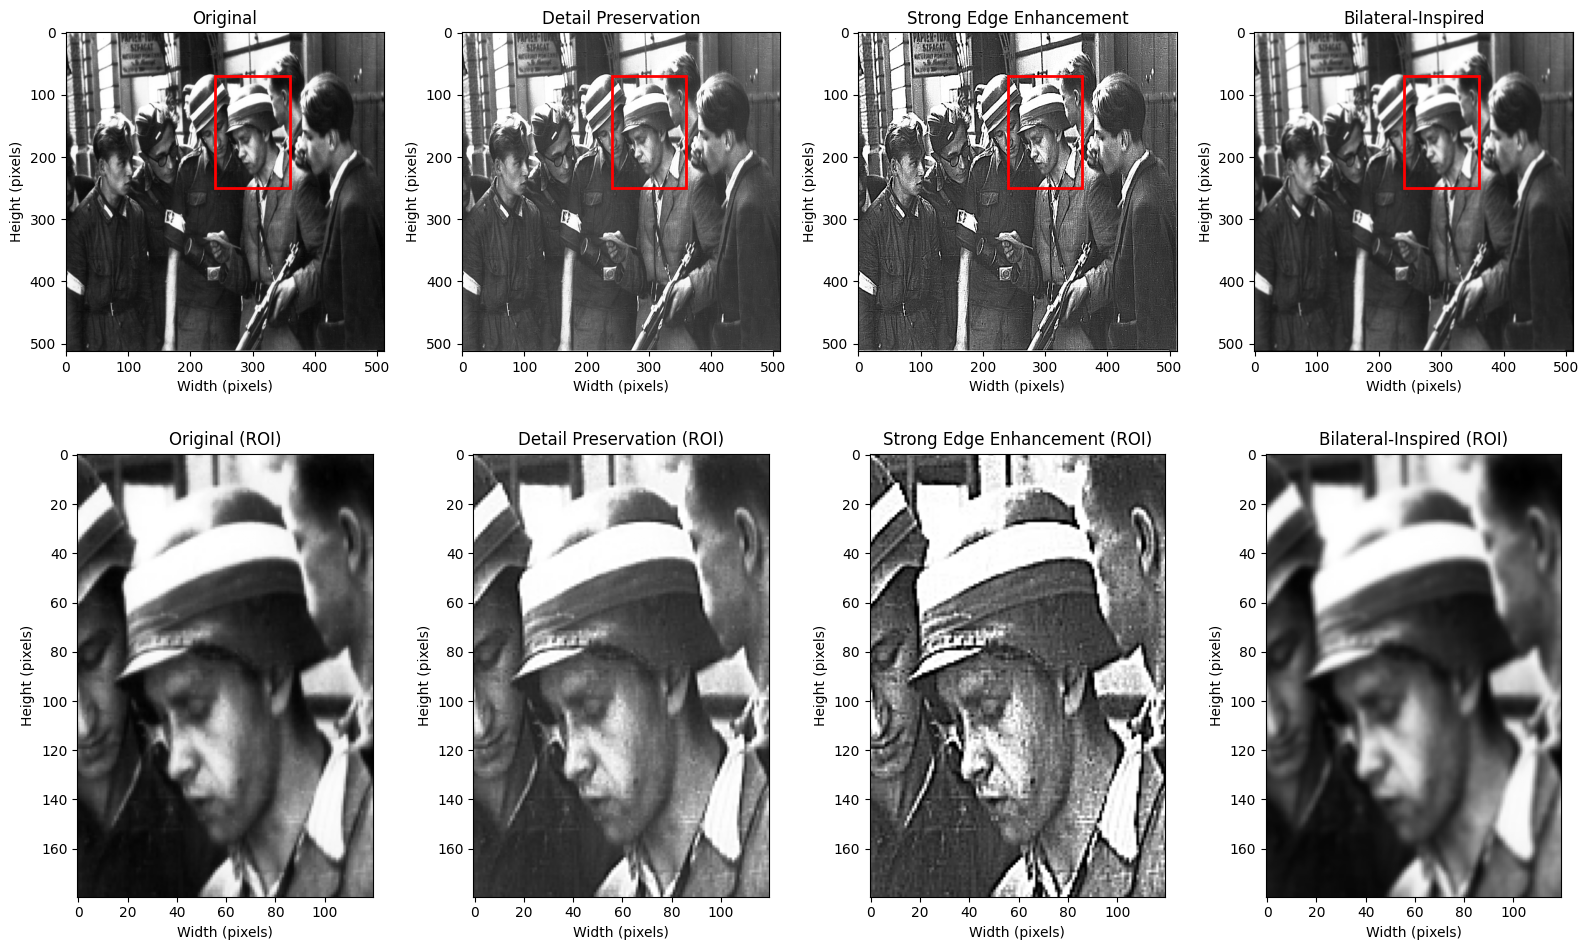

In [2]:
import numpy as np
from skimage import color
from skimage.transform import resize
from urllib.request import urlopen
from io import BytesIO
from PIL import Image
from helper_functions import *


print("DAY 9: CONVOLUTION KERNELS - HISTORICAL PHOTO RESTORATION")
print("-" * 70)
# Load the Warsaw Uprising image
url = "https://cms-v2-files.idcom-jst.pl/sites/316/wiadomosci/73115/fotos/orign/powstancyzkompaniikosztaczytajaprawdopodobnieniemieckaulotkenaulicysienkiewiczarogmarszalkowskiej_foteugeniuszlokajski_muzeumpowstaniawarszawskiego.jpg"

# Download and convert image
response = urlopen(url)
img_original = np.array(Image.open(BytesIO(response.read())))

# Convert to grayscale if it's color
if len(img_original.shape) == 3:
    img = color.rgb2gray(img_original)
else:
    img = img_original / 255.0  # Normalize if already grayscale

# Resize for computational efficiency
img = resize(img, (512, 512))

print(f"\nImage loaded and processed: Shape: {img.shape}, Type: {img.dtype}")

# Define region of interest (faces and document being read)
roi = (70, 250, 240, 360)  # (y1, y2, x1, x2)
print(f"Region of Interest defined: {roi} - focused on faces and document")

print("\n" + "-" * 70)
print("EXPERIMENT 1: BASIC RESTORATION TECHNIQUES")
print("-" * 70)

# Define basic restoration kernels
print("Implementing three basic restoration techniques:")

# 1. Gaussian Smoothing Kernel (noise reduction)
gaussian_3x3 = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

print("\n1. Gaussian Smoothing (3x3):")
print("   Purpose: Reduce noise while preserving edges")
print("   Rationale: Historical photos often contain film grain and noise")
visualize_kernel(gaussian_3x3, "Gaussian Smoothing (3x3)")

# 2. Sharpening Kernel (enhance details)
sharpen_3x3 = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

print("\n2. Sharpening Kernel (3x3):")
print("   Purpose: Enhance edges and details")
print("   Rationale: Historical photos often suffer from loss of detail and low contrast")
visualize_kernel(sharpen_3x3, "Sharpening (3x3)")

# 3. Unsharp Masking Kernel (enhance details while controlling noise)
unsharp_mask = np.array([
    [1, 4, 6, 4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, -476, 24, 6],  # Central value = -476 = -500 + 24
    [4, 16, 24, 16, 4],
    [1, 4, 6, 4, 1]
]) / -256  # Normalize and invert

print("\n3. Unsharp Masking (5x5):")
print("   Purpose: Enhance details while controlling noise")
print("   Rationale: Combines smoothing with sharpening for balanced restoration")
visualize_kernel(unsharp_mask, "Unsharp Masking (5x5)")

# Apply the basic kernels
gaussian_img = custom_convolution_2d(img, gaussian_3x3)
sharpen_img = custom_convolution_2d(img, sharpen_3x3)
unsharp_img = custom_convolution_2d(img, unsharp_mask)

# Ensure output is properly normalized
gaussian_img = np.clip(gaussian_img, 0, 1)
sharpen_img = np.clip(sharpen_img, 0, 1)
unsharp_img = np.clip(unsharp_img, 0, 1)

# Display results of basic restoration
basic_images = [gaussian_img, sharpen_img, unsharp_img]
basic_titles = ["Gaussian Smoothing", "Sharpening", "Unsharp Masking"]
display_results(img, basic_images, basic_titles, roi)

print("\n" + "-" * 70)
print("EXPERIMENT 2: ADVANCED RESTORATION TECHNIQUES")
print("-" * 70)

print("Implementing three advanced restoration techniques:")

# 1. Custom Detail Preservation Filter
detail_preservation = np.array([
    [-0.1, -0.2, -0.1],
    [-0.2, 2.2, -0.2],
    [-0.1, -0.2, -0.1]
])

print("\n1. Detail Preservation Filter (3x3):")
print("   Purpose: Enhance details while minimizing noise amplification")
print("   Rationale: Custom-designed to balance detail enhancement and noise control")
visualize_kernel(detail_preservation, "Detail Preservation (3x3)")

# 2. Strong Edge Enhancement
edge_enhance = np.array([
    [-0.5, -1, -0.5],
    [-1, 7, -1],
    [-0.5, -1, -0.5]
])

print("\n2. Strong Edge Enhancement (3x3):")
print("   Purpose: Significantly enhance edges and structural elements")
print("   Rationale: Stronger parameters for cases where text or facial features need emphasis")
visualize_kernel(edge_enhance, "Strong Edge Enhancement (3x3)")

# 3. Custom Bilateral-Inspired Filter
# This is a simplified approximation of bilateral filtering concepts
bilateral_inspired = np.array([
    [0.5, 0.75, 0.5],
    [0.75, 1, 0.75],
    [0.5, 0.75, 0.5]
])
bilateral_inspired = bilateral_inspired / np.sum(bilateral_inspired)

print("\n3. Bilateral-Inspired Filter (3x3):")
print("   Purpose: Edge-preserving smoothing")
print("   Rationale: Inspired by bilateral filtering to reduce noise while preserving edges")
visualize_kernel(bilateral_inspired, "Bilateral-Inspired (3x3)")

# Apply the advanced kernels
detail_img = custom_convolution_2d(img, detail_preservation)
edge_enhance_img = custom_convolution_2d(img, edge_enhance)
bilateral_img = custom_convolution_2d(img, bilateral_inspired)

# Ensure output is properly normalized
detail_img = np.clip(detail_img, 0, 1)
edge_enhance_img = np.clip(edge_enhance_img, 0, 1)
bilateral_img = np.clip(bilateral_img, 0, 1)

# Display results of advanced restoration
advanced_images = [detail_img, edge_enhance_img, bilateral_img]
advanced_titles = ["Detail Preservation", "Strong Edge Enhancement", "Bilateral-Inspired"]
display_results(img, advanced_images, advanced_titles, roi)


ROI - Region of interests

Image Source: Warsaw Uprising Museum - https://cms-v2-files.idcom-jst.pl/sites/316/wiadomosci/73115/fotos/orign/powstancyzkompaniikosztaczytajaprawdopodobnieniemieckaulotkenaulicysienkiewiczarogmarszalkowskiej_foteugeniuszlokajski_muzeumpowstaniawarszawskiego.jpg
Description: Insurgents from the Koszta company reading a German leaflet on Sienkiewicza Street at the corner of Marszałkowska Street. Photo by Eugeniusz Lokajski.


CONCLUSIONS:

1. Effectiveness of Different Techniques:
   - Basic filters like sharpening are effective for quick enhancement of historical photos
   - Advanced techniques like strong edge enhancement provide the best detail recovery

2. Optimal Parameters:
   - For detail enhancement Strong edge enhancement offers the best results
   - The best looking photo to me is when Unsharp masking is used


These convolution-based techniques provide effective tools for enhancing historical 
photographs from the Warsaw Uprising, improving their value for historical documentation,
research, and education while preserving the authentic character of these important
historical artifacts.

